# Introduction
In this notebook we implement the Perceptron Learning Algorithm.

- Algorithms: Perceptron Learning Algorithm (PLA) and the Pocket extension
- DataSets:   "perceptron", "pocket" and "breast_cancer"
- Video: To Be Added


# Perceptron
The hypothesis set for the Perceptron is

$$ H=\{h(x)=\text{sign}(w^T x) \mid w\in \mathbb{R}^{d+1}\}$$

Given data $D=\{(x_1, y_1), ..., (x_N, y_N)\}$ we want to minimize the following error function  

$$E_{in}(h)=\sum_{i=1}^N \mathbb{1}_{h(x_i)\neq y_i} $$

Here $\mathbb{1}_{h(x_i)\neq y_i}$ is the indicator function 

$$\mathbb{1}_{h(x_i)\neq y_i} = \begin{cases}
1 &\text{if }h(x_i) \neq y_i\\
0 &\text{else}
\end{cases}$$

Notice that any hypothesis $h(x)=\text{sign}(w^Tx)\in H$ is described exactly by its weights $w\in R^{d+1}$. Our goal is to find weights $w$ such that we minimize the in-sample error $E_{in}$. 

Run the following code. It will visualize a set of data

<IPython.core.display.Javascript object>


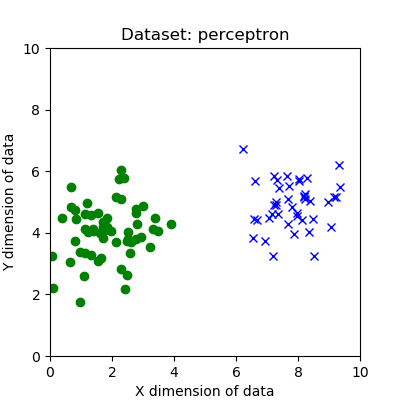

In [1]:
import ipython_import_class
import DataSet as ds

data = ds.DataSet("perceptron", 100)
data.plot() 

Notice that the two groups of points could be seperated by a line. We say that the data is *linearly seperable*. The following algorithm is called the Perceptron Learning Algorithm. If the data is *linearly seperable* it will find a seperating line. This will make the perceptron classify all points correctly and thus get $E_{in}(h)=0$ !

       Perceptron Learning Algorithm
       w = initialize random
       while there is a misclassified point x in D
          pick misclassified point x
          update weights w = w + learning_rate * x * y
      
It can be proved that 

$$\text{D is linearly seperable}\quad\Rightarrow \quad\text{The PLA algorithm finds a seperating hyperplane in finite steps}$$

Several proofs [1,2,3] are available online (the proof is not a part of the AU ML 2017 curriculum). 

# Code: Perceptron 
The following code implements the class `Perceptron`. For simplicity all visualization code has been moved to `hide_visualization_code`. 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import ipython_import_class
import DataSet as ds
import hide_visualization_code

class Perceptron:

    def __init__(self, learning_rate=0.01, visualize=False, sleep=0.0):
        self.w = None
        self.learning_rate = learning_rate
        self.visualize = visualize
        self.sleep = sleep
        self.xlim = None
        self.ylim = None
        
        if self.visualize: 
            hide_visualization_code.init_perceptron(self)
            
    def fit(self, X, y):
        """ Train the Perceptron on data X with labels y. 
        
        Parameters
        ----------
        X:    Matrix with shape (n, d) with data point x_i as the i'th row.   
        y:    Array with shape (n, ) with label y_i on the i'th entry. 
        """
        n, d = X.shape
        
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {0, +1}: y = y*2-1
        elif set(y) != {-1, +1}: assert False, ("Labels should be {-1, +1} for Perceptron but was: ", set(y))
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a misclassified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)

        while not all_classified_corectly:
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * misclassified_point * misclassified_label
        
            # Get a new misclassified point. 
            all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)

    def misclassified(self, X, y):
        """ Finds a misclassified label, returns False if all points are correctly classified. """
        # Predict the class of each data point. 
        predictions = self.predict(X)
        
        # Get the number of miss classified points
        misclassified_count = sum(predictions != y)
        
        # Return False if all points are correctly classified. 
        if misclassified_count == 0: return True, None, None
        
        # Filter out the points where predictions disagree with labels. 
        misclassified_points = X[predictions != y]
        misclassified_labels = y[predictions != y]
        
        # Return te first miss classified point
        return False, misclassified_points[0], misclassified_labels[0]
        
    def classification_error(self, X, y):
        """ Compute the error """
        n, d = X.shape
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {0, +1}: y = y*2-1
        elif set(y) != {-1, +1}: assert False, ("Labels should be {-1, +1} for Perceptron but was: ", set(y))
        
        return np.mean(self.predict(X) != y) 
    
    def predict(self, X):
        """ Predicts the class of X given the trained weights. """
        return np.sign(X @ self.w)
    
    def visualize_step(self, X, y, subclass=False): 
        hide_visualization_code.visualize_perceptron(self, X, y, subclass)

Let's try to run the `Perceptron` algorithm on the dataset! I have written code that will visualize each step of the algorithm. The arrow in the visualization points to the misclassified point picked in the while loop. 

<IPython.core.display.Javascript object>


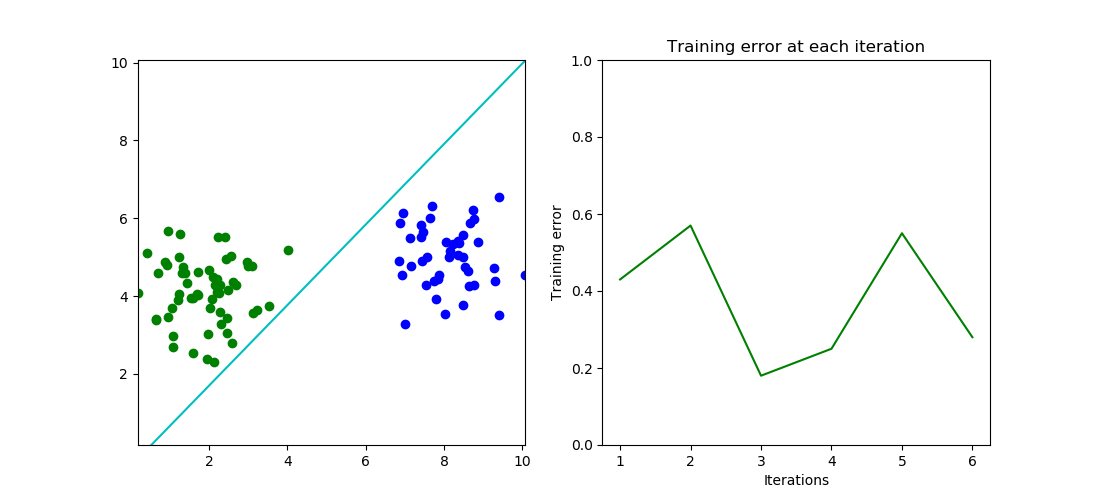

Classification Error:  0.0


In [3]:
data = ds.DataSet("perceptron")

perceptron = Perceptron(learning_rate=1, visualize=True, sleep=0.75)
perceptron.fit(data.X, data.y)

print("Classification Error: ", perceptron.classification_error(data.X, data.y))

The Perceptron Learning Algorithm will eventually find a line seperating the data, however, it might take a while. To visualize the algorithm I added `sleep=0.75` in the code above. This forces the algorithm to pause 0.75 seconds each iteration so we can see what happens. 

The used dataset is generated randomly. The time it takes to classify the data will vary a bit. You might want to change `sleep=0` to speed it up. 

# Pocket
Unfortunately, it is very rare that our data is linearly seperable. Try to run the following code, it will visualize data that is not lienarly seperable 

<IPython.core.display.Javascript object>


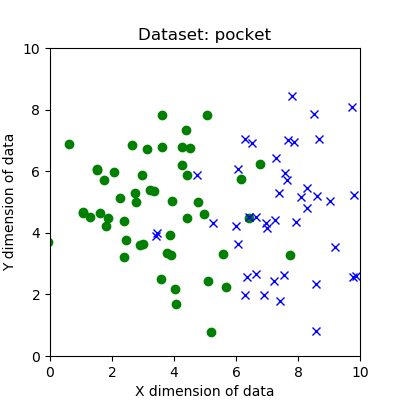

In [4]:
data = ds.DataSet("pocket")
data.plot()

If we run the `Perceptron` on this dataset it would run forever. How could we fix this? We change the *while* loop to a *for loop* with T iterations and return the best weights. The best weights are the weight with smallest in-sample error $E_{in}(w)$.   

       Pocket Learning Algorithm
       w = initialize random
       for i=1,...,T
          pick misclassified point x (if none stop)
          update weights w = w + learning_rate * x * y
          compute in-sample error of w 
          if error is better than previous weights save w 
      return best w of all T iterations
      
You can think of this as storing the current best weights in your pocket.

# Code: The Pocket Algorithm

The following code implements the class `Pocket`. It is a simple modification of the class `Perceptron`. It runs $T$ iterations and returns the best hypothesis of the $T$ hypothesis. 

The `Pocket` class inherits the functions of the `Perceptron` class, so you need to run the code above.

In [5]:
class Pocket(Perceptron): 
    
    def fit(self, X, y, T=20000):
        """ Train the Perceptron on data X with labels y. At each iteration evaluate the performance
        of the current weights. Save the weights with the best performance and return these weights
        after T iterations. """
        n, d = X.shape
        
        # labels should be {0, 1} and not {-1, +1}
        if set(y) == {0, 1}: y = y*2-1
        elif set(y) != {-1, +1}: assert False, ("Labels should be {-1, +1} for Perceptron but was: ", set(y))
        
        # Initialize weights 
        self.w = np.zeros(d)
        
        # Get a misclassified point. If all are classified correctly, the 
        # function will return False. 
        all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
        
        # Initialize best error to the worst
        best_error = 1.0
        self.best_w = np.zeros(d)

        for i in range(T): 
            # Visualize if enabled
            if self.visualize: self.visualize_step(X, y)
            
            # Update weights
            self.w += self.learning_rate * misclassified_point * misclassified_label
        
            # If current error is better than previous update best error and 
            # best weights. 
            current_error = self.classification_error(X, y)
            if current_error < best_error: 
                best_error = current_error
                self.best_w = np.copy(self.w) # copy and save the best weights.
                # If we get zero in-sample error we are done. 
                if best_error == 0:
                    return
                
            # Get a new misclassified point. 
            all_classified_corectly, misclassified_point, misclassified_label = self.misclassified(X, y)
            
        # Visualize the last round if enabled
        if self.visualize: self.visualize_step(X, y)
            
        # Set the final weights to the best weights
        self.w = self.best_w
            
    def visualize_step(self, X, y):
        # Let Perceptron draw step as usually, then do our own stuff afterwards. 
        super().visualize_step(X, y, subclass=True)
        hide_visualization_code.visualize_pocket(self, X, y)

Let's run the Pocket algorithm on some data! The visualization plots the best hypothesis soo far with dashed lines. 

<IPython.core.display.Javascript object>


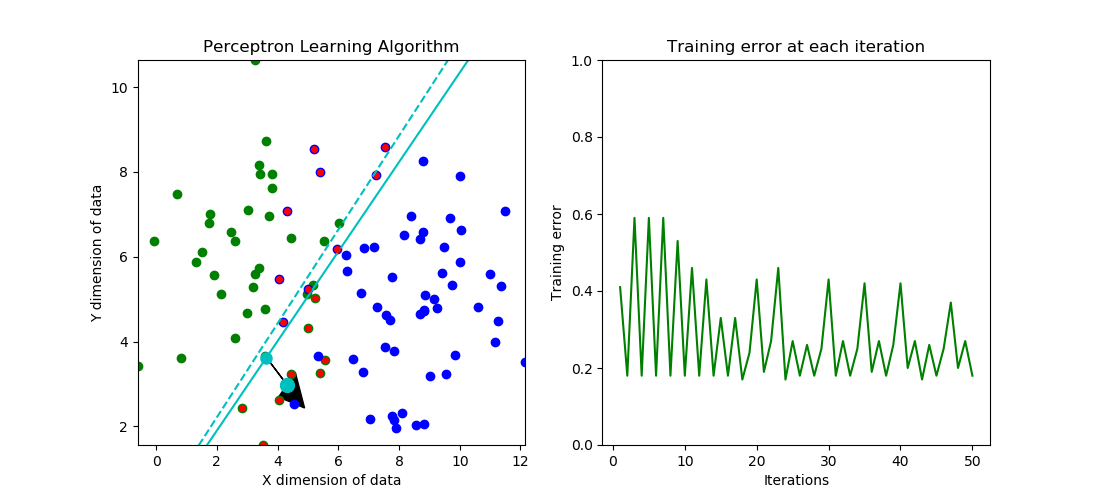

Classification Error:  0.17


In [6]:
data = ds.DataSet("pocket")

pocket = Pocket(learning_rate = 1, visualize = True, sleep=0.1)
pocket.fit(data.X, data.y, 50)

print("Classification Error: ", pocket.classification_error(data.X, data.y))

# Experiment: Breast Cancer
You have now seen a visualization of each step of `Perceptron` and `Pocket`. I generated the data we used myself to allow a nice visualization of the algorithms. In this section we will explore running `Pocket` on real data instead of artificial generated data.

The dataset we are going to use is called `breast_cancer` [4]. The data $X$ and the labels $y$ are   

\begin{align}
X:& \quad\text{characteristics of the breast cell nuclei}\\
y:& \quad\text{malevolent or benign (cancer/not cancer)}
\end{align}

The original dataset measured 30 different characteristisc of breast cell nuclei. To simplify matters and allow us to visualize our algorithm, I reduced the 30 dimensions to 2 in a "smart way" [5]. What I mean by "smart way" will be covered later on. For now you should just think of the breast cancer data as being 2d dimensional.  

Let's check out the dataset. 

<IPython.core.display.Javascript object>


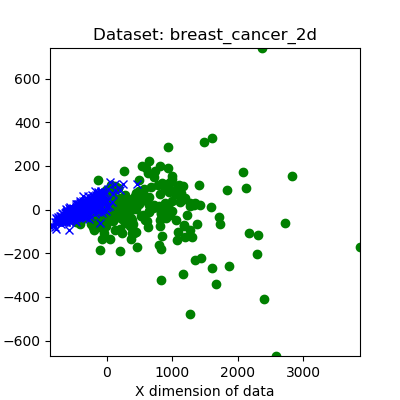

In [7]:
import ipython_import_class
import DataSet as ds

data = ds.DataSet("breast_cancer_2d")
data.plot()

Let's try to run the `Pocket` algorithm on the dataset for $40$ iterations! You can speed up the time the algorithm takes by disabling visualization (`visualize=False`). 

<IPython.core.display.Javascript object>


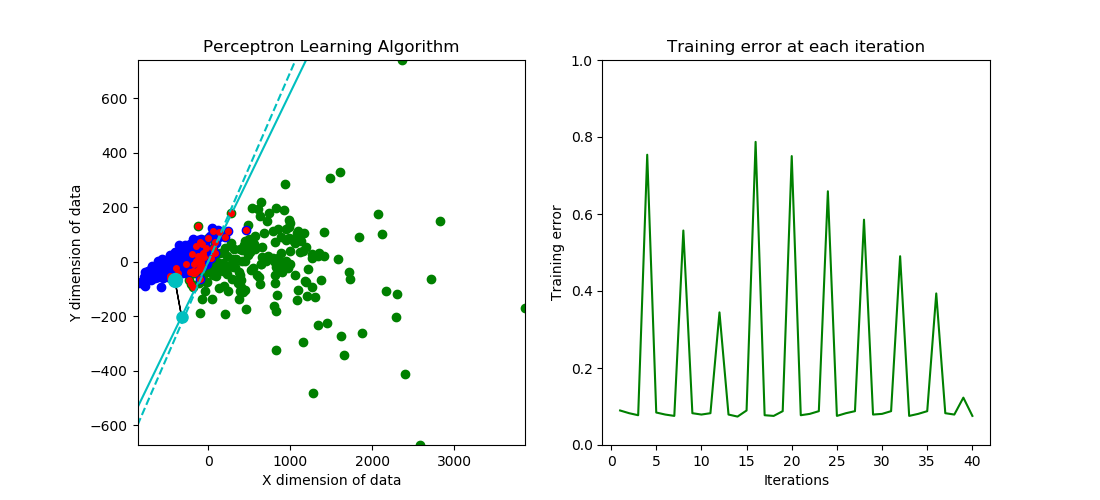

Error of best weights:  0.0738137082601


In [8]:
data = ds.DataSet("breast_cancer_2d")
data.normalize_mean()

p = Pocket(visualize=True, learning_rate=1)
p.fit(data.X, data.y, 40)

print("Error of best weights: ", p.classification_error(data.X, data.y))

This should give around 7.5% in-sample error. You might run try to increase `iterations` and see if this would give you a better in-sample error. It probably wont get much better because the data isn't linearly seperable, many of the blue and green points even lie on top of each other. 

There is one thing we can do to improve performance slightly. Remember that the data originally had 30 dimensions. Learning directly on the entire data will take more time, but we will probably get better in-sample error! To reduce the time (and because the data isn't 2d) we will turn visualization off (`visualization=False`).  

In [9]:
data = ds.DataSet("breast_cancer")

pocket = Pocket(visualize=False)
pocket.fit(data.X, data.y, 1000)
pocket.classification_error(data.X, data.y)

0.05272407732864675

So, that's it. Our first algorithm can classify roughly $95$% of our breast cancer dataset correctly! The next two notebooks explore two different linear models: Linear Regression and Logistic Regression. 

# References
[1] http://www.cs.columbia.edu/~mcollins/courses/6998-2012/notes/perc.converge.pdf

[2] https://ocw.mit.edu/courses/electrical-engineering-and-computer-science/6-867-machine-learning-fall-2006/lecture-notes/lec2.pdf

[3] http://www.cems.uvm.edu/~rsnapp/teaching/cs295ml/notes/perceptron.pdf

[4] http://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+%28diagnostic%29

[5] I used a technique called Principle Component Analysis (PCA). This will be covered in later iPython Notebooks.

# Errors, Suggestions and Hall Of Fame
If you find any mistakes or have suggestions for improvements reach me at alexmath@cs.au.dk. Any help is very much appreciated, I'll even add your name below for super-awesome everlasting fame!

- ...

# (todo) Discussion

<iframe src="..discussionboard/perceptron.html" style="width: 800px; height: 800px; "/></iframe>